#Download Dataset#

In [1]:
!pip install -q gdown

import gdown
import zipfile
import os

file_id = "1AgFlGYaEg4YWtmYzkN97O7jhKFPsKltD"
destination = "data.zip"
gdown.download(f"https://drive.google.com/uc?id={file_id}", destination, quiet=False)

with zipfile.ZipFile(destination, 'r') as zip_ref:
    zip_ref.extractall('./')

os.remove(destination)

Downloading...
From: https://drive.google.com/uc?id=1AgFlGYaEg4YWtmYzkN97O7jhKFPsKltD
To: /content/data.zip
100%|██████████| 23.2M/23.2M [00:00<00:00, 50.0MB/s]


#Import Libraries

In [2]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from glob import glob
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Feature Engineering Techniques#

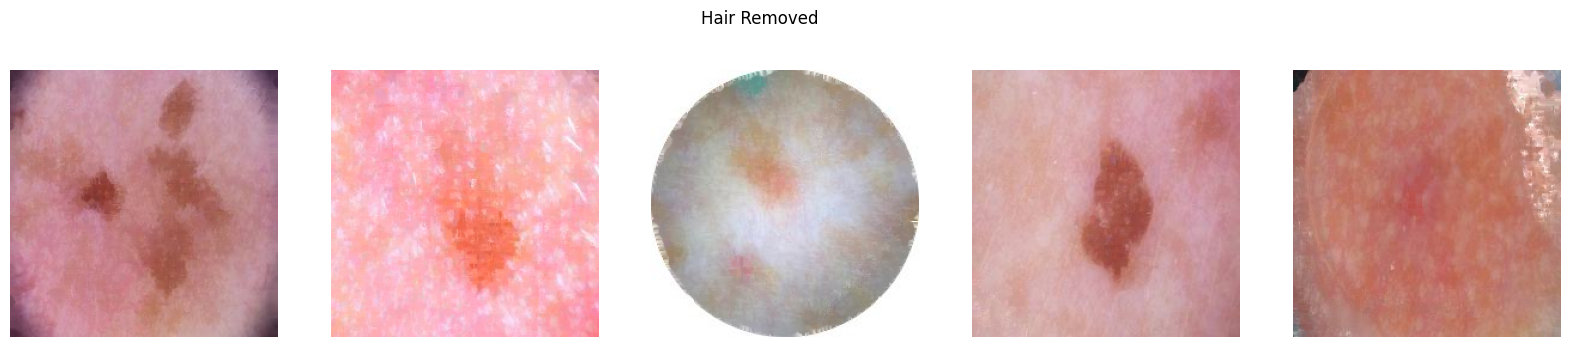

In [3]:
def remove_hair(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    kernel = cv2.getStructuringElement(1, (17, 17))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)
    _, mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    result = cv2.inpaint(img, cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY), 1, cv2.INPAINT_TELEA)
    return result

# Display 5 images
sample_paths = glob("/content/ISIC Dataset/Train/Benign/*.jpg")[:5]
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, path in enumerate(sample_paths):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    no_hair = remove_hair(img)
    axs[i].imshow(no_hair)
    axs[i].axis('off')
plt.suptitle("Hair Removed")
plt.show()


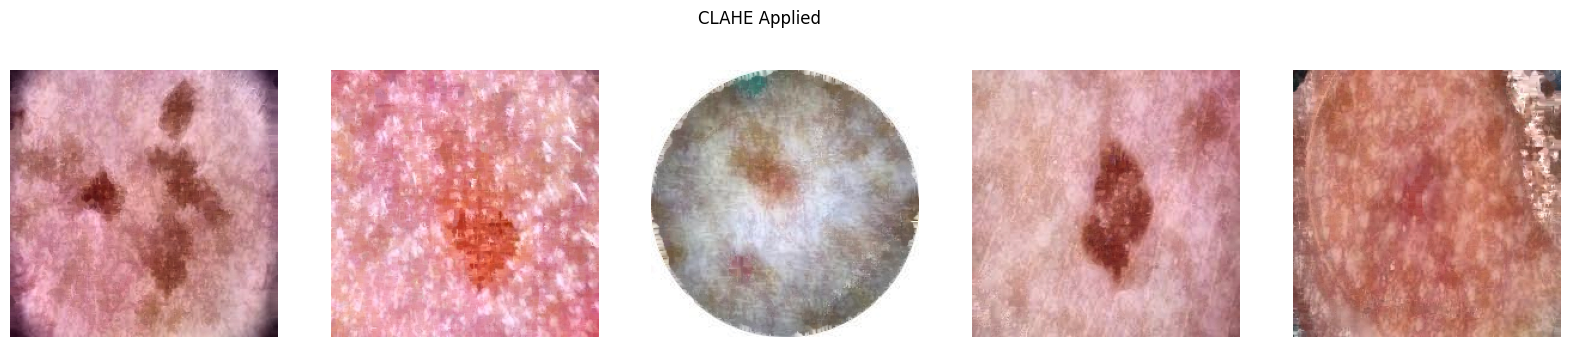

In [4]:
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return final

# Display 5 images
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, path in enumerate(sample_paths):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    no_hair = remove_hair(img)
    eq = apply_clahe(no_hair)
    axs[i].imshow(eq)
    axs[i].axis('off')
plt.suptitle("CLAHE Applied")
plt.show()


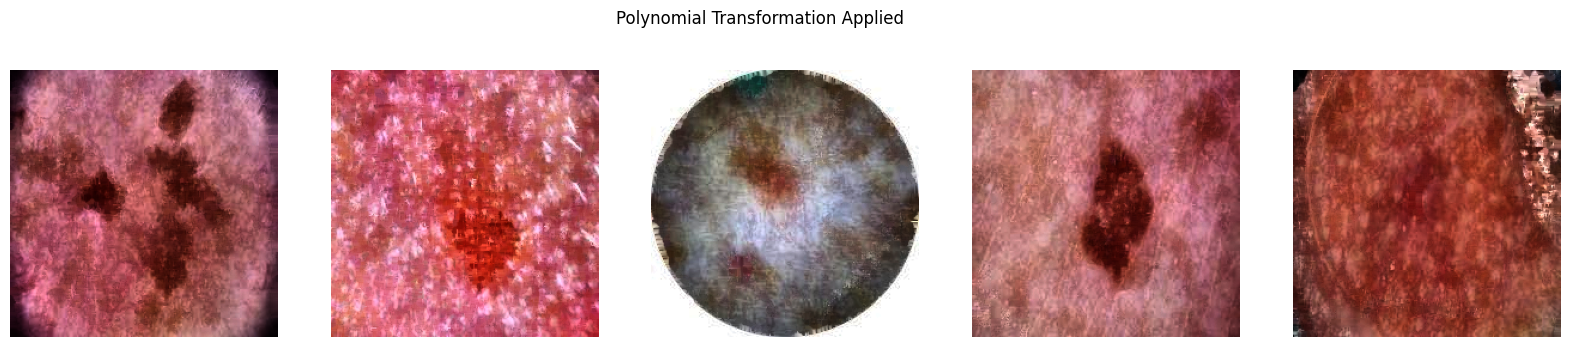

In [5]:
def poly_transform(img):
    img = img.astype(np.float32) / 255.0
    poly_img = np.power(img, 2.0)
    poly_img = (poly_img * 255).astype(np.uint8)
    return poly_img

# Display 5 images
fig, axs = plt.subplots(1, 5, figsize=(20, 4))
for i, path in enumerate(sample_paths):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    processed = poly_transform(apply_clahe(remove_hair(img)))
    axs[i].imshow(processed)
    axs[i].axis('off')
plt.suptitle("Polynomial Transformation Applied")
plt.show()


#Preprocess and Transform Dataset#

In [6]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
from torchvision.io import read_image

class CustomSkinDataset(Dataset):
    def __init__(self, root_dir, transform=None, augment=False):
        self.dataset = ImageFolder(root_dir)
        self.transform = transform
        self.augment = augment

    def __getitem__(self, idx):
        img_path, label = self.dataset.imgs[idx]
        img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
        img = remove_hair(img)
        img = apply_clahe(img)
        img = poly_transform(img)
        img = Image.fromarray(img)
        if self.augment:
            img = self.transform(img)
        else:
            img = self.transform(img)
        return img, label

    def __len__(self):
        return len(self.dataset)

train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor()
])

test_transform = transforms.Compose([
    transforms.ToTensor()
])



Load Dataset

In [7]:
# Load datasets
train_data = CustomSkinDataset("/content/ISIC Dataset/Train", transform=train_transform, augment=True)
val_data = CustomSkinDataset("/content/ISIC Dataset/Val", transform=test_transform)
test_data = CustomSkinDataset("/content/ISIC Dataset/Test", transform=test_transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32)
test_loader = DataLoader(test_data, batch_size=32)


#DenseNet121#

In [8]:
model = models.densenet121(pretrained=True)
model.classifier = nn.Linear(model.classifier.in_features, 2)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 201MB/s]


In [9]:
best_acc = 0
for epoch in range(15):
    model.train()
    train_loss, correct, total = 0, 0, 0
    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_acc = 100. * correct / total
    print(f"Epoch {epoch+1}, Train Acc: {train_acc:.2f}%, Loss: {train_loss/len(train_loader):.4f}")

    # Validation
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for imgs, labels in tqdm(val_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    val_acc = 100. * correct / total
    print(f"Validation Acc: {val_acc:.2f}%")

    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "best_model.pth")
        print("Best Model Saved")


100%|██████████| 84/84 [01:02<00:00,  1.35it/s]


Epoch 1, Train Acc: 81.62%, Loss: 0.3984


100%|██████████| 21/21 [00:08<00:00,  2.44it/s]


Validation Acc: 84.19%
Best Model Saved


100%|██████████| 84/84 [00:55<00:00,  1.51it/s]


Epoch 2, Train Acc: 89.02%, Loss: 0.2609


100%|██████████| 21/21 [00:09<00:00,  2.31it/s]


Validation Acc: 84.49%
Best Model Saved


100%|██████████| 84/84 [00:54<00:00,  1.55it/s]


Epoch 3, Train Acc: 91.63%, Loss: 0.2038


100%|██████████| 21/21 [00:09<00:00,  2.29it/s]


Validation Acc: 84.94%
Best Model Saved


100%|██████████| 84/84 [00:53<00:00,  1.56it/s]


Epoch 4, Train Acc: 92.83%, Loss: 0.1702


100%|██████████| 21/21 [00:09<00:00,  2.32it/s]


Validation Acc: 84.34%


100%|██████████| 84/84 [00:53<00:00,  1.56it/s]


Epoch 5, Train Acc: 94.62%, Loss: 0.1300


100%|██████████| 21/21 [00:09<00:00,  2.31it/s]


Validation Acc: 85.69%
Best Model Saved


100%|██████████| 84/84 [00:54<00:00,  1.55it/s]


Epoch 6, Train Acc: 95.63%, Loss: 0.1160


100%|██████████| 21/21 [00:08<00:00,  2.49it/s]


Validation Acc: 86.14%
Best Model Saved


100%|██████████| 84/84 [00:54<00:00,  1.54it/s]


Epoch 7, Train Acc: 96.82%, Loss: 0.0862


100%|██████████| 21/21 [00:09<00:00,  2.27it/s]


Validation Acc: 84.64%


100%|██████████| 84/84 [00:54<00:00,  1.55it/s]


Epoch 8, Train Acc: 98.17%, Loss: 0.0573


100%|██████████| 21/21 [00:09<00:00,  2.29it/s]


Validation Acc: 87.50%
Best Model Saved


100%|██████████| 84/84 [00:53<00:00,  1.56it/s]


Epoch 9, Train Acc: 98.24%, Loss: 0.0480


100%|██████████| 21/21 [00:09<00:00,  2.27it/s]


Validation Acc: 89.16%
Best Model Saved


100%|██████████| 84/84 [00:54<00:00,  1.54it/s]


Epoch 10, Train Acc: 97.87%, Loss: 0.0638


100%|██████████| 21/21 [00:08<00:00,  2.38it/s]


Validation Acc: 86.75%


100%|██████████| 84/84 [00:54<00:00,  1.54it/s]


Epoch 11, Train Acc: 97.98%, Loss: 0.0595


100%|██████████| 21/21 [00:08<00:00,  2.37it/s]


Validation Acc: 85.69%


100%|██████████| 84/84 [00:54<00:00,  1.54it/s]


Epoch 12, Train Acc: 98.17%, Loss: 0.0489


100%|██████████| 21/21 [00:09<00:00,  2.27it/s]


Validation Acc: 86.45%


100%|██████████| 84/84 [00:54<00:00,  1.55it/s]


Epoch 13, Train Acc: 98.13%, Loss: 0.0515


100%|██████████| 21/21 [00:09<00:00,  2.27it/s]


Validation Acc: 83.89%


100%|██████████| 84/84 [00:54<00:00,  1.54it/s]


Epoch 14, Train Acc: 98.62%, Loss: 0.0452


100%|██████████| 21/21 [00:09<00:00,  2.31it/s]


Validation Acc: 85.99%


100%|██████████| 84/84 [00:54<00:00,  1.53it/s]


Epoch 15, Train Acc: 98.73%, Loss: 0.0431


100%|██████████| 21/21 [00:08<00:00,  2.44it/s]

Validation Acc: 86.75%


In [10]:
# Load best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

y_true, y_pred = [], []
y_scores = []

with torch.no_grad():
    for imgs, labels in tqdm(val_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)  # logits or probabilities
        probs = torch.softmax(outputs, dim=1)[:, 1]  # get score for class 1 (Malignant)

        _, preds = outputs.max(1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())

print(classification_report(y_true, y_pred, target_names=["Benign", "Malignant"]))


100%|██████████| 21/21 [00:09<00:00,  2.31it/s]

              precision    recall  f1-score   support

      Benign       0.90      0.89      0.89       339
   Malignant       0.89      0.89      0.89       325

    accuracy                           0.89       664
   macro avg       0.89      0.89      0.89       664
weighted avg       0.89      0.89      0.89       664



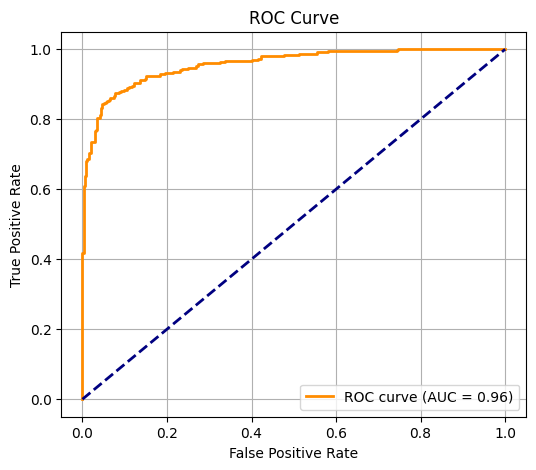

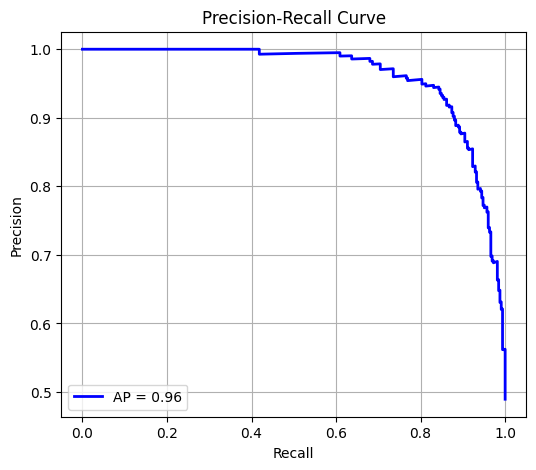

In [11]:
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)
ap_score = average_precision_score(y_true, y_scores)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='blue', lw=2, label=f'AP = {ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()


#VGG-16#

In [12]:
from torchvision.models import vgg16

# Load pre-trained VGG16 and modify final layer
vgg = vgg16(pretrained=True)
vgg.classifier[6] = nn.Linear(vgg.classifier[6].in_features, 2)
vgg = vgg.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(vgg.parameters(), lr=1e-4)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 88.9MB/s]


In [13]:
# Initialize lists for graphs
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

best_acc = 0

for epoch in range(18):
    vgg.train()
    total_train_loss = 0
    correct_train, total_train = 0, 0

    for imgs, labels in tqdm(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item()
        _, preds = outputs.max(1)
        correct_train += preds.eq(labels).sum().item()
        total_train += labels.size(0)

    train_acc = 100 * correct_train / total_train
    train_loss = total_train_loss / len(train_loader)

    # Validation
    vgg.eval()
    total_val_loss = 0
    correct_val, total_val = 0, 0

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = vgg(imgs)
            loss = criterion(outputs, labels)
            total_val_loss += loss.item()
            _, preds = outputs.max(1)
            correct_val += preds.eq(labels).sum().item()
            total_val += labels.size(0)

    val_acc = 100 * correct_val / total_val
    val_loss = total_val_loss / len(val_loader)

    # Save the best metrics
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(vgg.state_dict(), "best_vgg16.pth")
        print(f"Best Model Saved")

    # Register metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch+1} | Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")


100%|██████████| 21/21 [00:10<00:00,  2.09it/s]


Best Model Saved
Epoch 1 | Train Acc: 72.51%, Val Acc: 78.61%, Train Loss: 0.5455, Val Loss: 0.4134


100%|██████████| 21/21 [00:10<00:00,  2.07it/s]


Best Model Saved
Epoch 2 | Train Acc: 78.71%, Val Acc: 79.82%, Train Loss: 0.4411, Val Loss: 0.4290


100%|██████████| 21/21 [00:10<00:00,  2.10it/s]


Epoch 3 | Train Acc: 83.68%, Val Acc: 76.51%, Train Loss: 0.3633, Val Loss: 0.4125


100%|██████████| 21/21 [00:10<00:00,  1.98it/s]


Epoch 4 | Train Acc: 84.39%, Val Acc: 67.92%, Train Loss: 0.3465, Val Loss: 0.6279


100%|██████████| 21/21 [00:10<00:00,  2.07it/s]


Best Model Saved
Epoch 5 | Train Acc: 84.65%, Val Acc: 84.04%, Train Loss: 0.3429, Val Loss: 0.3549


100%|██████████| 21/21 [00:10<00:00,  2.01it/s]


Epoch 6 | Train Acc: 86.10%, Val Acc: 83.43%, Train Loss: 0.3024, Val Loss: 0.3428


100%|██████████| 21/21 [00:10<00:00,  1.97it/s]


Epoch 7 | Train Acc: 88.31%, Val Acc: 83.28%, Train Loss: 0.2598, Val Loss: 0.3480


100%|██████████| 21/21 [00:10<00:00,  2.06it/s]


Epoch 8 | Train Acc: 87.93%, Val Acc: 79.22%, Train Loss: 0.2758, Val Loss: 0.4437


100%|██████████| 21/21 [00:10<00:00,  1.98it/s]


Best Model Saved
Epoch 9 | Train Acc: 88.76%, Val Acc: 84.94%, Train Loss: 0.2654, Val Loss: 0.3718


100%|██████████| 21/21 [00:15<00:00,  1.35it/s]


Epoch 10 | Train Acc: 90.29%, Val Acc: 84.49%, Train Loss: 0.2195, Val Loss: 0.3383


100%|██████████| 21/21 [00:11<00:00,  1.88it/s]


Epoch 11 | Train Acc: 93.24%, Val Acc: 82.23%, Train Loss: 0.1666, Val Loss: 0.4036


100%|██████████| 21/21 [00:10<00:00,  2.02it/s]


Epoch 12 | Train Acc: 93.09%, Val Acc: 80.72%, Train Loss: 0.1740, Val Loss: 0.5533


100%|██████████| 21/21 [00:10<00:00,  2.01it/s]


Epoch 13 | Train Acc: 93.05%, Val Acc: 84.79%, Train Loss: 0.1729, Val Loss: 0.3751


100%|██████████| 21/21 [00:10<00:00,  2.01it/s]


Epoch 14 | Train Acc: 94.77%, Val Acc: 84.49%, Train Loss: 0.1266, Val Loss: 0.3739


100%|██████████| 21/21 [00:10<00:00,  1.99it/s]


Epoch 15 | Train Acc: 94.92%, Val Acc: 84.64%, Train Loss: 0.1277, Val Loss: 0.4746


100%|██████████| 21/21 [00:10<00:00,  2.01it/s]


Epoch 16 | Train Acc: 95.41%, Val Acc: 83.73%, Train Loss: 0.1141, Val Loss: 0.3854


100%|██████████| 21/21 [00:10<00:00,  2.01it/s]


Best Model Saved
Epoch 17 | Train Acc: 95.07%, Val Acc: 86.14%, Train Loss: 0.1266, Val Loss: 0.4379


100%|██████████| 21/21 [00:10<00:00,  2.01it/s]

Epoch 18 | Train Acc: 97.27%, Val Acc: 81.33%, Train Loss: 0.0717, Val Loss: 0.6822


In [14]:
torch.save(vgg.state_dict(), "Final_vgg16.pth")

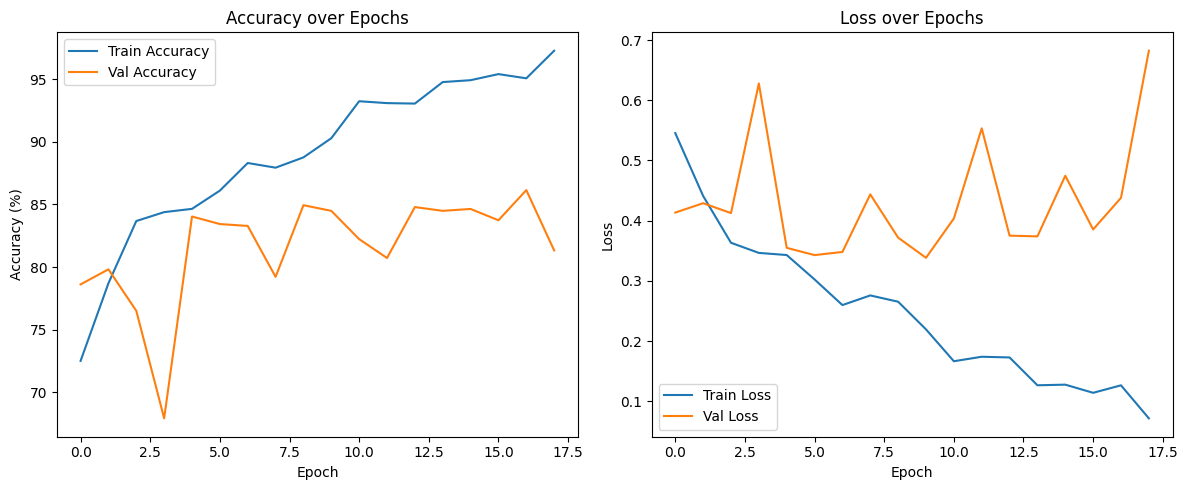

In [15]:
# Plot accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
# Load the best model
vgg.load_state_dict(torch.load("best_vgg16.pth"))
vgg.eval()

y_true, y_pred = [], []
y_scores = []

with torch.no_grad():
    for imgs, labels in tqdm(val_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = vgg(imgs)  # logits or probabilities
        probs = torch.softmax(outputs, dim=1)[:, 1]  # get score for class 1 (Malignant)

        _, preds = outputs.max(1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())
        y_scores.extend(probs.cpu().numpy())



# Report
print(classification_report(y_true, y_pred, target_names=["Benign", "Malignant"]))


100%|██████████| 21/21 [00:10<00:00,  2.06it/s]

              precision    recall  f1-score   support

      Benign       0.86      0.87      0.86       339
   Malignant       0.86      0.86      0.86       325

    accuracy                           0.86       664
   macro avg       0.86      0.86      0.86       664
weighted avg       0.86      0.86      0.86       664



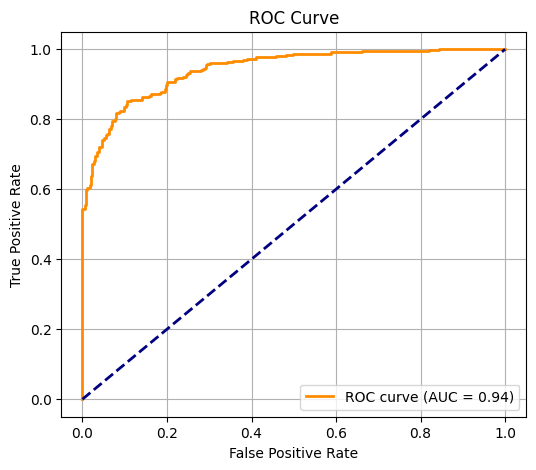

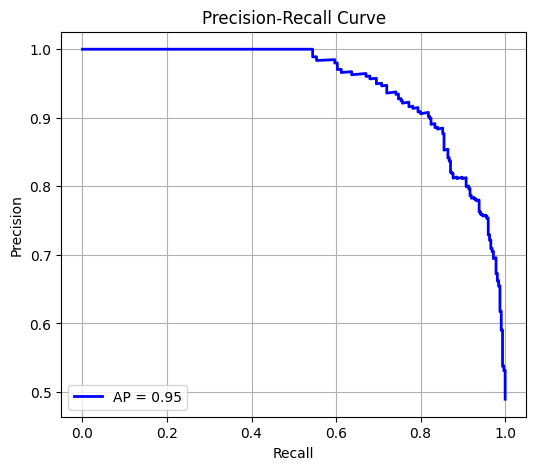

In [17]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_scores)
ap_score = average_precision_score(y_true, y_scores)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, color='blue', lw=2, label=f'AP = {ap_score:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.grid(True)
plt.show()

#Inference#

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


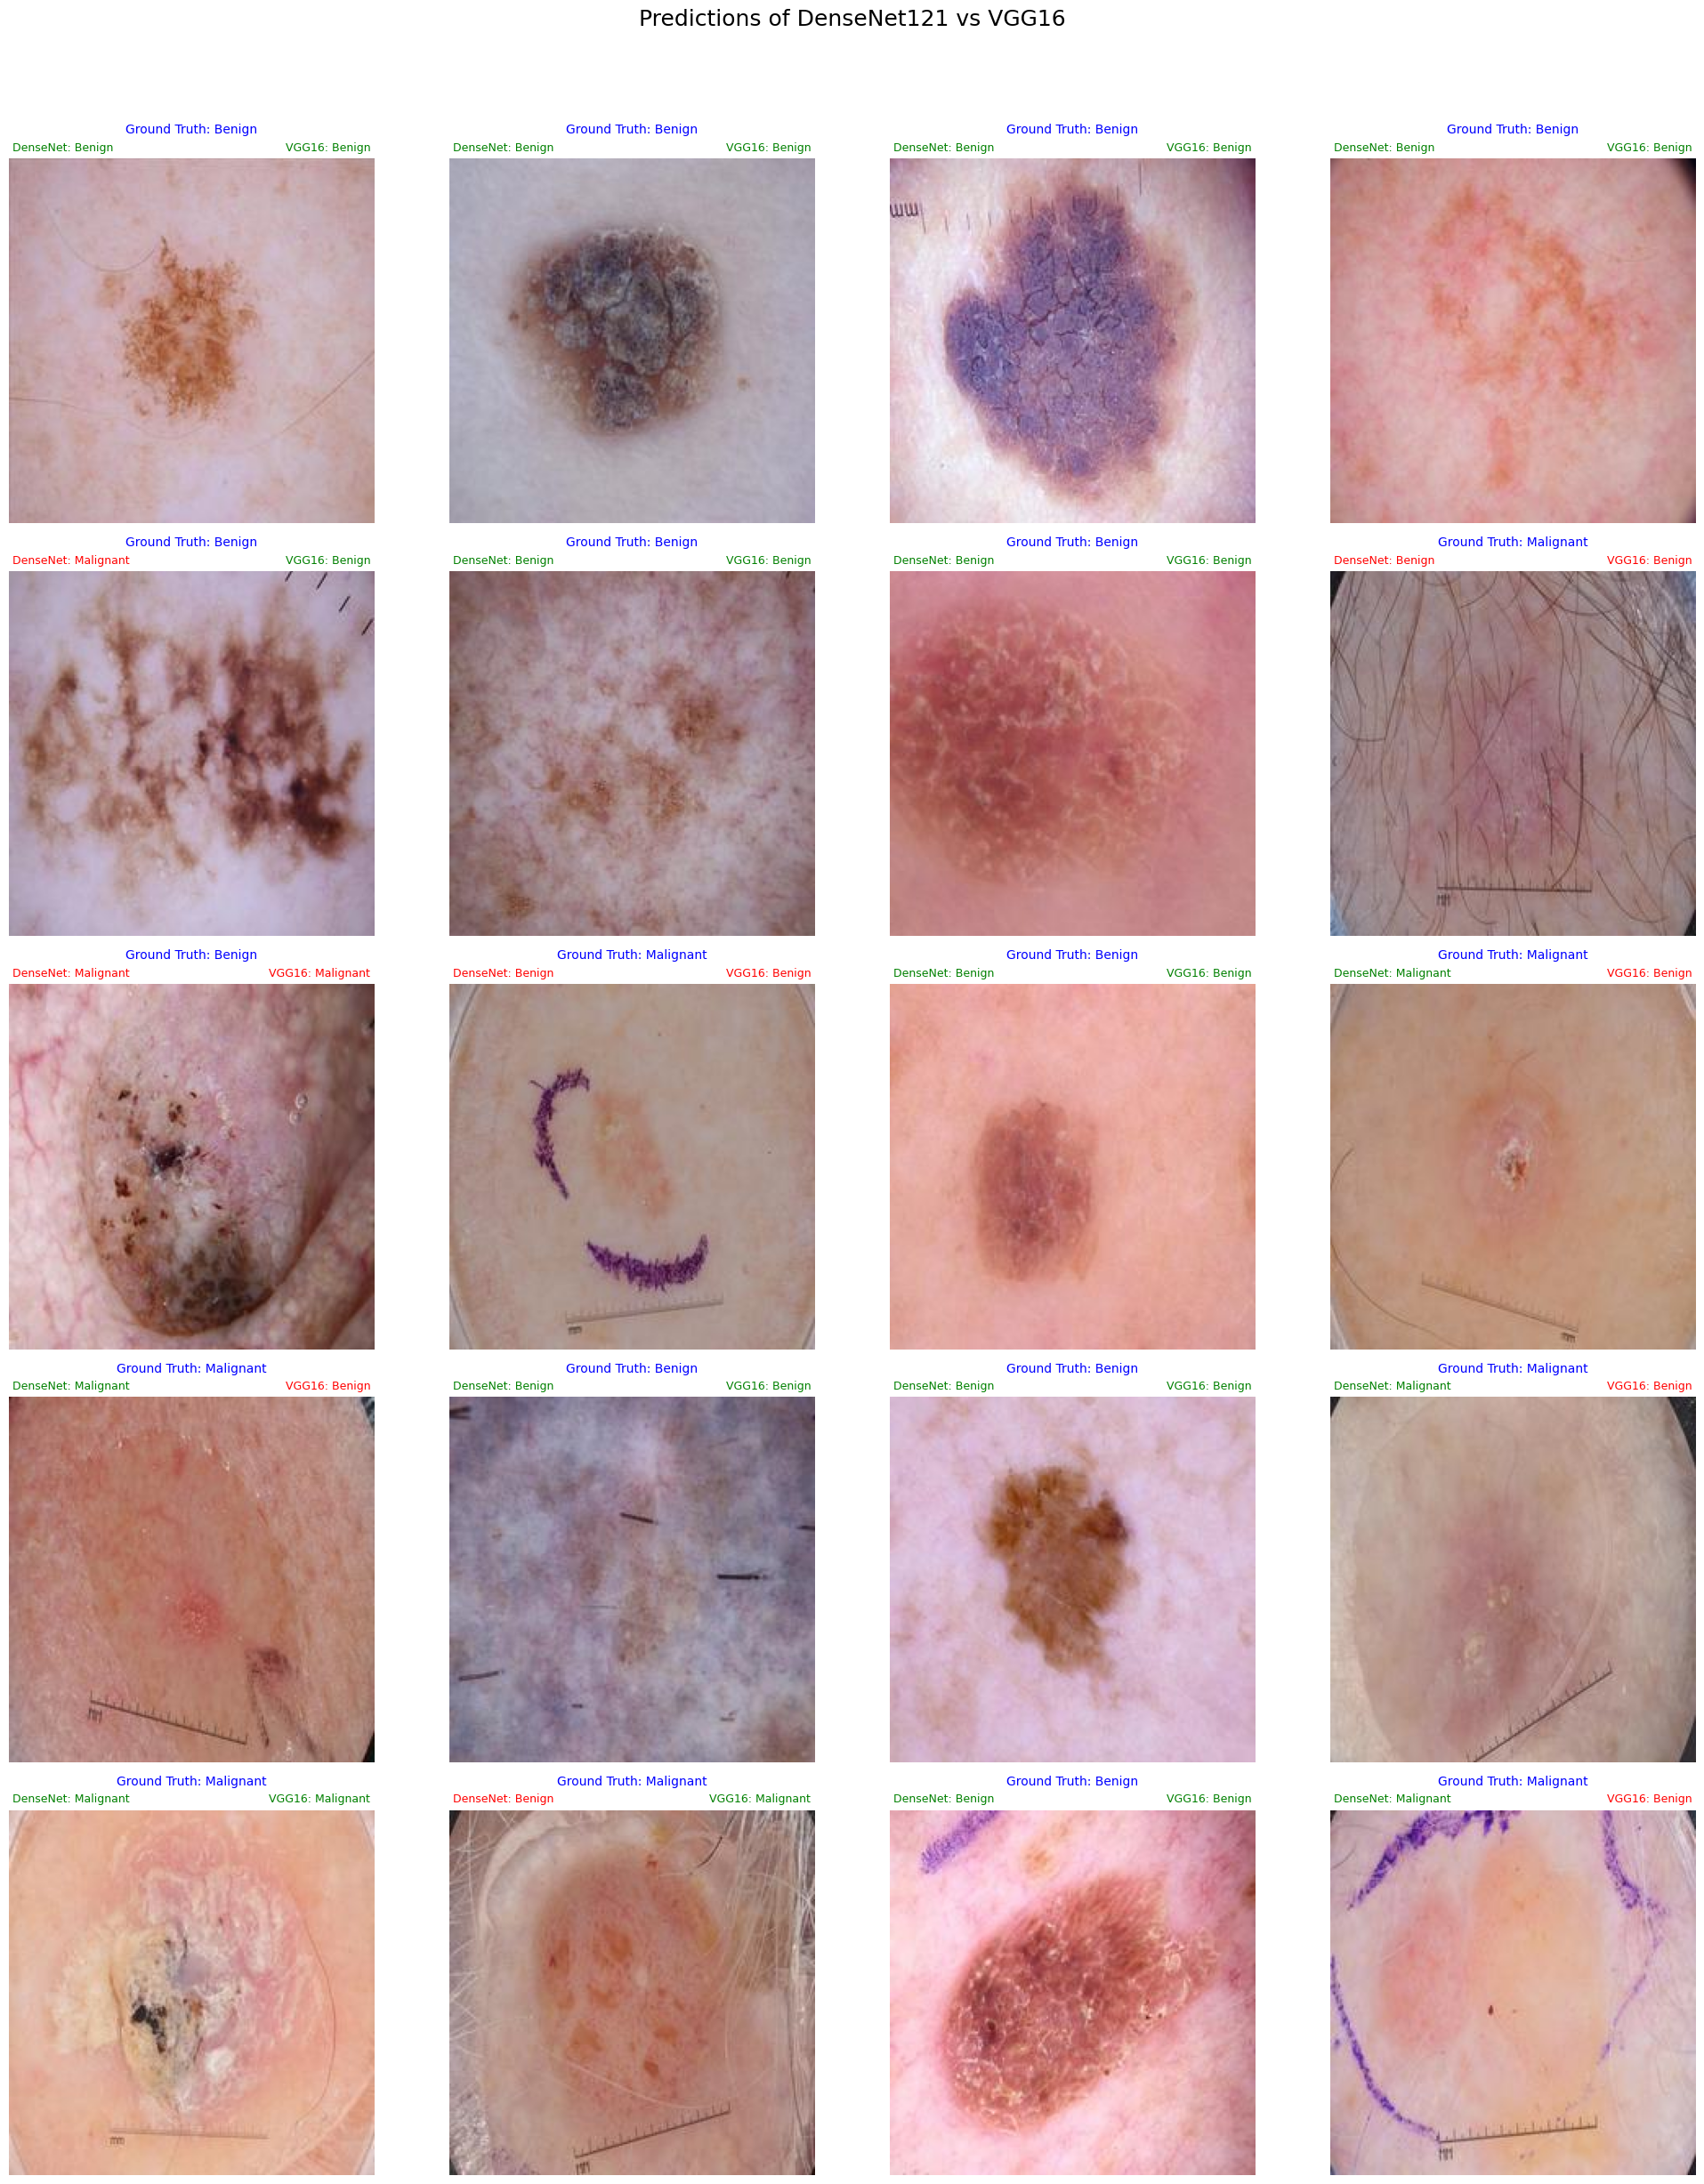

In [18]:
import random

# nsure reproducibility
random.seed(42)

# Classes
class_names = ["Benign", "Malignant"]

# Load trained models
densenet = models.densenet121(pretrained=False)
densenet.classifier = nn.Linear(densenet.classifier.in_features, 2)
densenet.load_state_dict(torch.load("best_model.pth"))
densenet.to(device).eval()

vgg = vgg16(pretrained=False)
vgg.classifier[6] = nn.Linear(vgg.classifier[6].in_features, 2)
vgg.load_state_dict(torch.load("best_vgg16.pth"))
vgg.to(device).eval()

# Select 20 random images from test dataset
all_test_paths = glob("/content/ISIC Dataset/Test/*/*.jpg")
sample_paths = random.sample(all_test_paths, 20)

# Function to preprocess an image as in test_loader
def preprocess_image(path):
    img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
    img = remove_hair(img)
    img = apply_clahe(img)
    img = poly_transform(img)
    img = Image.fromarray(img)
    img = test_transform(img)
    return img.unsqueeze(0)  # Adds batch dimension

def get_prediction(model, img_tensor):
    with torch.no_grad():
        return model(img_tensor).argmax(dim=1).item()

def get_label_color(pred, true_label):
    return 'green' if pred == true_label else 'red'

# Show images with predictions
n_cols = 4
n_rows = (len(sample_paths) + n_cols - 1) // n_cols
plt.figure(figsize=(20, n_rows * 5))

for idx, path in enumerate(sample_paths):
    img_tensor = preprocess_image(path).to(device)
    true_label = 0 if "benign" in path.lower() else 1

    # Get predictions
    pred_dense = get_prediction(densenet, img_tensor)
    pred_vgg = get_prediction(vgg, img_tensor)

    # load image
    img_disp = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)

    # show image
    ax = plt.subplot(n_rows, n_cols, idx + 1)
    ax.imshow(img_disp)
    ax.axis('off')

    # Ground Truth
    ax.set_title(f"Ground Truth: {class_names[true_label]}", fontsize=10, color='blue', pad=20)


    ax.text(0.01, 1.02, f"DenseNet: {class_names[pred_dense]}",
            color=get_label_color(pred_dense, true_label), fontsize=9, transform=ax.transAxes, ha='left')
    ax.text(0.99, 1.02, f"VGG16: {class_names[pred_vgg]}",
            color=get_label_color(pred_vgg, true_label), fontsize=9, transform=ax.transAxes, ha='right')

plt.suptitle("Predictions of DenseNet121 vs VGG16", fontsize=18)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


